In [44]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from tqdm import tqdm
from statsmodels.tsa.seasonal import STL

In [ ]:


# Download stock data for Indomaret (IMFI.JK)
stock_data = yf.download("IMAS.JK", start="2015-01-01", end="2024-01-01")

# Calculate various technical indicators
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_15'] = stock_data['Close'].rolling(window=15).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['EMA_9'] = stock_data['Close'].ewm(span=9, adjust=False).mean()
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
delta = stock_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))
highest_high = stock_data['High'].rolling(window=14).max()
lowest_low = stock_data['Low'].rolling(window=14).min()
stock_data['WPR'] = ((highest_high - stock_data['Close']) / (highest_high - lowest_low)) * -100
stock_data['BB_Middle'] = stock_data['Close'].rolling(window=20).mean()
stock_data['BB_Upper'] = stock_data['BB_Middle'] + 2 * stock_data['Close'].rolling(window=20).std()
stock_data['BB_Lower'] = stock_data['BB_Middle'] - 2 * stock_data['Close'].rolling(window=20).std()
stock_data['ATR'] = stock_data['High'] - stock_data['Low']
stock_data['Stochastic_K'] = 100 * (stock_data['Close'] - stock_data['Low'].rolling(window=14).min()) / (stock_data['High'].rolling(window=14).max() - stock_data['Low'].rolling(window=14).min())
stock_data['OBV'] = np.where(stock_data['Close'] > stock_data['Close'].shift(1), stock_data['Volume'], 
                             np.where(stock_data['Close'] < stock_data['Close'].shift(1), -stock_data['Volume'], 0)).cumsum()
stock_data['CMF'] = (stock_data['Close'] - stock_data['Low']) - (stock_data['High'] - stock_data['Close']) / (stock_data['High'] - stock_data['Low']) * stock_data['Volume']
stock_data['ROC'] = stock_data['Close'].pct_change(periods=12) * 100
stock_data['MFI'] = ((stock_data['Close'] - stock_data['Low']) + (stock_data['High'] - stock_data['Close'])) / stock_data['Volume']

# Drop NaN values after calculating technical indicators
stock_data.dropna(inplace=True)

# Download VIX data for Volatility Index
vix_data = yf.download('^VIX', start="2015-01-01", end="2024-01-01")
vix_data = vix_data[['Close']]  # Only keep 'Close' price of VIX
vix_data.rename(columns={'Close': 'VIX'}, inplace=True)

# Merge VIX data with stock data
stock_data = stock_data.join(vix_data, how='left')

# Add Time-based Features (Day, Month, Year)
stock_data['DayOfWeek'] = stock_data.index.dayofweek
stock_data['Month'] = stock_data.index.month
stock_data['Year'] = stock_data.index.year

# Add Lagged Features (Previous n days of Close price)
n_lags = 5  # Adjust based on how many previous days you want to include
for i in range(1, n_lags + 1):
    stock_data[f'Lag_{i}'] = stock_data['Close'].shift(i)

# Drop NaN values generated by lagged features
stock_data.dropna(inplace=True)

# Prepare Data for XGBoost Model
feature_columns = [
    'EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'MACD', 'Signal_Line', 'RSI', 'WPR', 
    'BB_Middle', 'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'OBV', 'CMF', 'ROC', 'MFI', 
    'DayOfWeek', 'Month', 'Year', 'VIX'
]
# Include Lagged features
feature_columns.extend([f'Lag_{i}' for i in range(1, n_lags + 1)])

X = stock_data[feature_columns]
y = stock_data['Close']

# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))

# Split data into train, validation, and test sets (60% Train, 20% Validation, 20% Test)
train_size = int(len(X_scaled) * 0.6)
val_size = int(len(X_scaled) * 0.2)
test_size = len(X_scaled) - train_size - val_size

X_train, X_val, X_test = X_scaled[:train_size], X_scaled[train_size:train_size + val_size], X_scaled[train_size + val_size:]
y_train, y_val, y_test = y_scaled[:train_size], y_scaled[train_size:train_size + val_size], y_scaled[train_size + val_size:]

# Function for MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create XGBoost model for Optuna optimization
def create_xgboost_optuna(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100)
    }
    model = xgb.XGBRegressor(**params)
    return model

# Optuna objective function for hyperparameter tuning
def objective(trial):
    model = create_xgboost_optuna(trial)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    predictions = model.predict(X_val)
    predictions_rescaled = scaler_target.inverse_transform(predictions.reshape(-1, 1))
    y_val_rescaled = scaler_target.inverse_transform(y_val)
    rmse = np.sqrt(mean_squared_error(y_val_rescaled, predictions_rescaled))
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\sandi\AppData\Local\Temp\ipykernel_20248\1407017130.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data.rename(columns={'Close': 'VIX'}, inplace=True)
[I 2024-12-05 19:02:32,064] A new study created in memory with name: no-name-a2c6f0c3-a9a8-4a19-8d5c-04e9dec74473
[I 2024-12-05 19:02:32,741] Trial 0 finished with value: 33.76232316405782 and parameters: {'learning_rate': 0.08540363562307358, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7490870143878077, 'colsample_bytree': 0.7889284113792836, 'n_estimators': 100}. Best is trial 0 with value: 33.76232316405782.
[I 2024-12-05 19:02:34,296] Trial 1 finished with value: 31.525662176537537 and 

Best parameters: {'learning_rate': 0.044376643790169146, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8235316907438927, 'colsample_bytree': 0.9100631175910711, 'n_estimators': 400}


c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


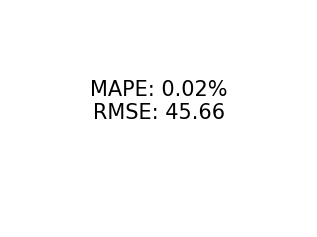

In [15]:
# Best parameters from Optuna
best_params = study.best_params
print("Best parameters:", best_params)

# Add eval_metric to the parameters
best_params['eval_metric'] = 'rmse'

# Convert data to DMatrix format (required by xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify the parameters for the XGBoost model
params = best_params
params['objective'] = 'reg:squarederror'

# Create a watchlist to monitor performance during training
watchlist = [(dtrain, 'train'), (dval, 'eval')]

# Train the model using xgb.train with early stopping
num_round = 1000  # Maximum number of rounds
early_stopping_rounds = 50

best_model = xgb.train(params, dtrain, num_round, watchlist, 
                  early_stopping_rounds=early_stopping_rounds, 
                  verbose_eval=False)

# Predictions and performance metrics on test data
predictions = best_model.predict(dtest)

# Rescale predictions and actual values
predictions_rescaled = scaler_target.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

# Final MAPE and RMSE
plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}', fontsize=15, ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Function to evaluate performance on different datasets
def evaluate_performance(model, X, y, scaler_target, dataset_name="Dataset"):
    # Convert X to DMatrix for prediction
    dX = xgb.DMatrix(X)
    
    predictions = model.predict(dX)  # Use DMatrix for prediction
    predictions_rescaled = scaler_target.inverse_transform(predictions.reshape(-1, 1))  # Reshape predictions
    y_rescaled = scaler_target.inverse_transform(y.reshape(-1, 1))  # Reshape actual values if necessary
    
    rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
    mae = mean_absolute_error(y_rescaled, predictions_rescaled)
    mape = mean_absolute_percentage_error(y_rescaled, predictions_rescaled)
    r2 = r2_score(y_rescaled, predictions_rescaled)

    print(f"{dataset_name} RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    return rmse, mae, mape, r2

# Evaluate on Training, Validation, and Test sets
print("\nPerformance on Training Set:")
train_rmse, train_mae, train_mape, train_r2 = evaluate_performance(best_model, X_train, y_train, scaler_target, "Training")

print("\nPerformance on Validation Set:")
val_rmse, val_mae, val_mape, val_r2 = evaluate_performance(best_model, X_val, y_val, scaler_target, "Validation")

print("\nPerformance on Test Set:")
test_rmse, test_mae, test_mape, test_r2 = evaluate_performance(best_model, X_test, y_test, scaler_target, "Test")


Performance on Training Set:
Training RMSE: 21.74, MAE: 15.87, MAPE: 0.01%, R2: 1.00

Performance on Validation Set:
Validation RMSE: 25.06, MAE: 19.44, MAPE: 0.02%, R2: 0.98

Performance on Test Set:
Test RMSE: 45.66, MAE: 28.26, MAPE: 0.02%, R2: 0.99


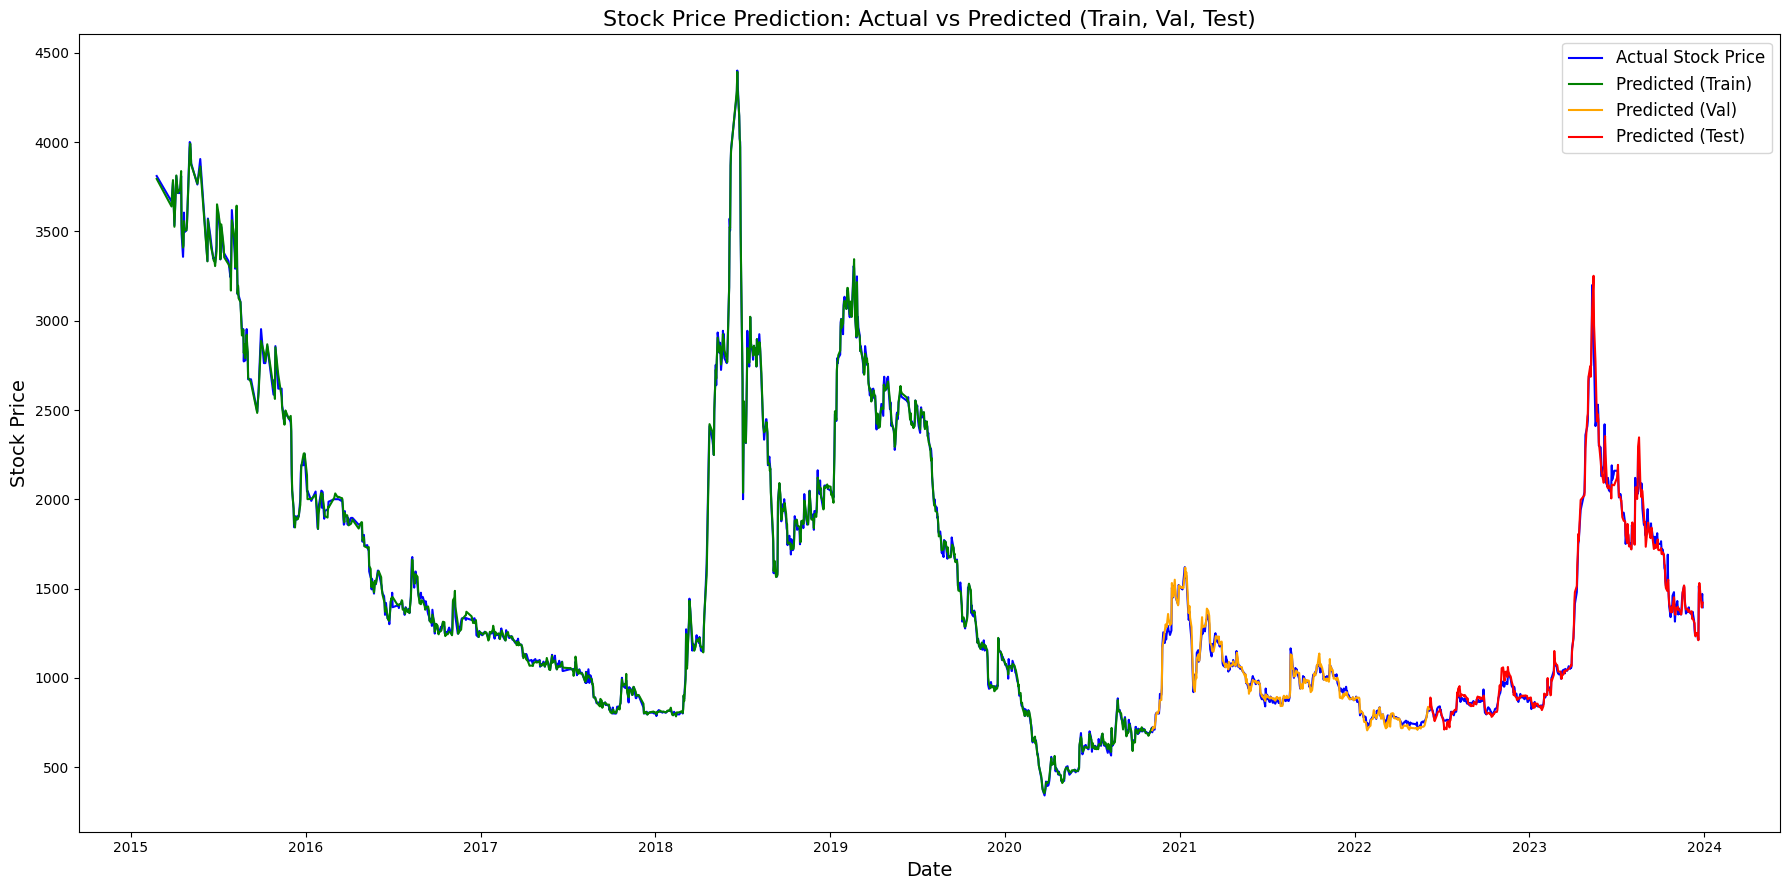

In [21]:
# Convert data to DMatrix format (required by XGBoost)
dtrain = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

# Ensure that the predictions on training, validation, and test sets are obtained
train_predictions = best_model.predict(dtrain)
val_predictions = best_model.predict(dval)
test_predictions = best_model.predict(dtest)

# Rescale the predictions back to the original scale
train_predictions_rescaled = scaler_target.inverse_transform(train_predictions.reshape(-1, 1))
val_predictions_rescaled = scaler_target.inverse_transform(val_predictions.reshape(-1, 1))
test_predictions_rescaled = scaler_target.inverse_transform(test_predictions.reshape(-1, 1))

# Rescale the actual values to the original scale
y_train_rescaled = scaler_target.inverse_transform(y_train.reshape(-1, 1))
y_val_rescaled = scaler_target.inverse_transform(y_val.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Plotting the four components: Actual, Training, Validation, and Test
plt.figure(figsize=(18, 9))  # Increase figure size here

# Plot actual stock prices (entire dataset)
plt.plot(stock_data.index[:len(y_train_rescaled) + len(y_val_rescaled) + len(y_test_rescaled)], 
         np.concatenate([y_train_rescaled, y_val_rescaled, y_test_rescaled]), 
         label='Actual Stock Price', color='blue')

# Plot predicted stock prices for training set
plt.plot(stock_data.index[:len(train_predictions_rescaled)], train_predictions_rescaled, label='Predicted (Train)', color='green')

# Plot predicted stock prices for validation set
plt.plot(stock_data.index[len(train_predictions_rescaled):len(train_predictions_rescaled) + len(val_predictions_rescaled)], 
         val_predictions_rescaled, label='Predicted (Val)', color='orange')

# Plot predicted stock prices for test set
plt.plot(stock_data.index[len(train_predictions_rescaled) + len(val_predictions_rescaled):], 
         test_predictions_rescaled, label='Predicted (Test)', color='red')

# Add title and labels
plt.title('Stock Price Prediction: Actual vs Predicted (Train, Val, Test)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

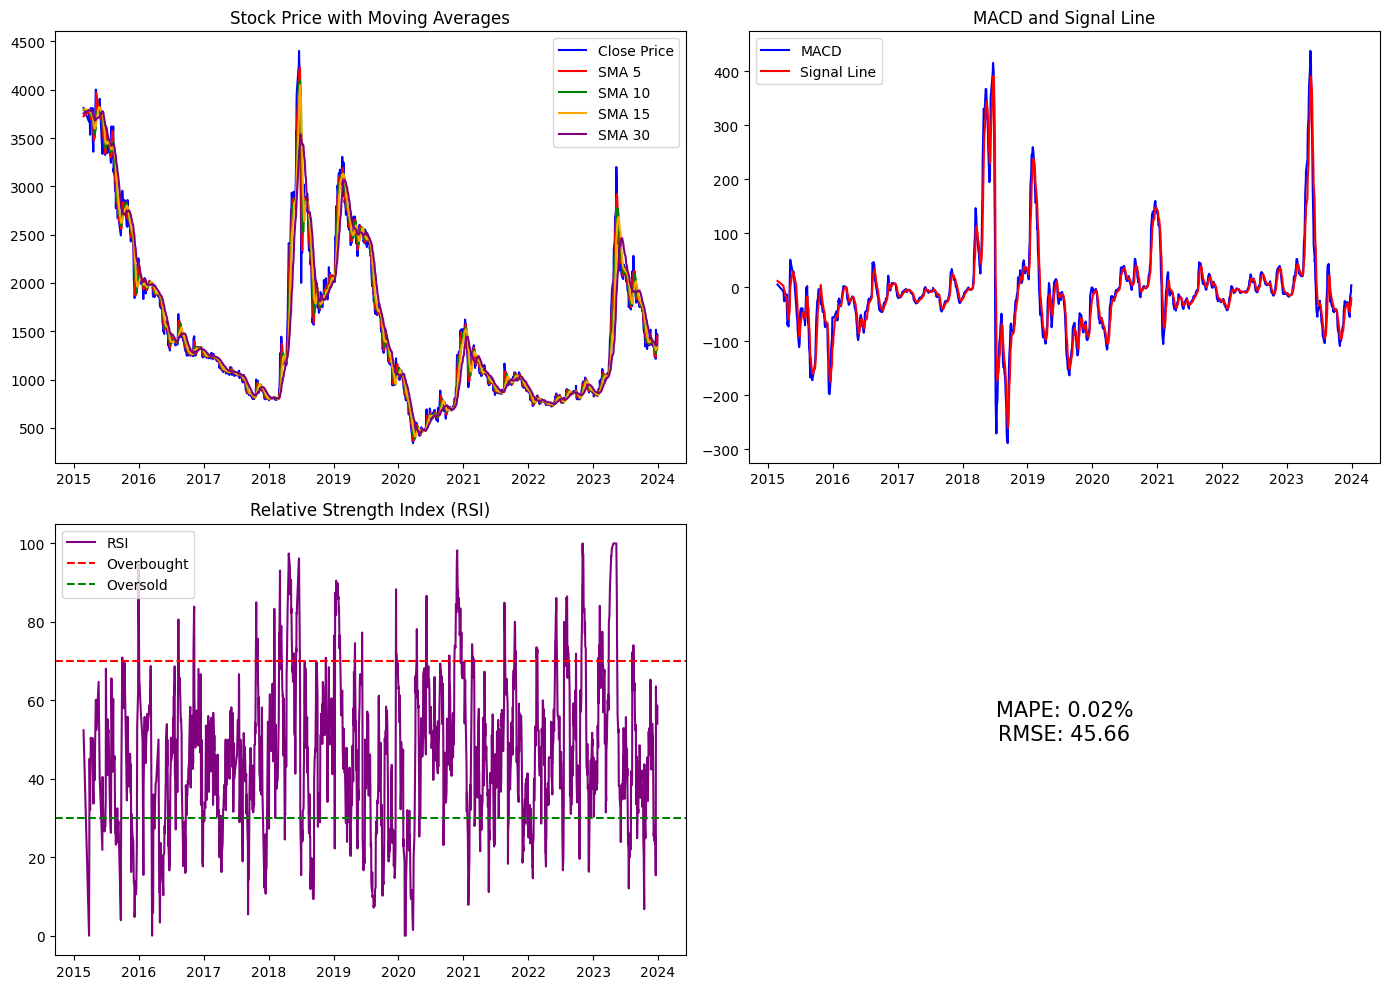

In [22]:
# Plotting stock data and indicators
plt.figure(figsize=(14, 10))

# Plot the closing price and moving averages
plt.subplot(2, 2, 1)
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['SMA_5'], label='SMA 5', color='red')
plt.plot(stock_data['SMA_10'], label='SMA 10', color='green')
plt.plot(stock_data['SMA_15'], label='SMA 15', color='orange')
plt.plot(stock_data['SMA_30'], label='SMA 30', color='purple')
plt.title('Stock Price with Moving Averages')
plt.legend(loc='best')

# Plot MACD and Signal Line
plt.subplot(2, 2, 2)
plt.plot(stock_data['MACD'], label='MACD', color='blue')
plt.plot(stock_data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.legend(loc='best')

# Plot RSI
plt.subplot(2, 2, 3)
plt.plot(stock_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.legend(loc='best')

# Final MAPE and RMSE
plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}', fontsize=15, ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

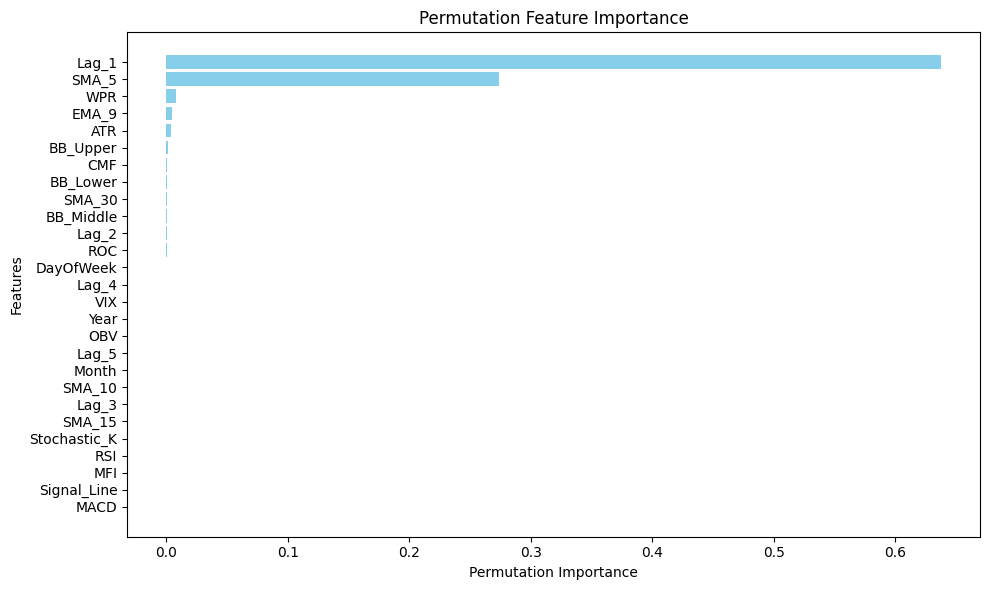

Features with low permutation importance (should consider deleting for next training):
MACD
Signal_Line
MFI
RSI
Stochastic_K


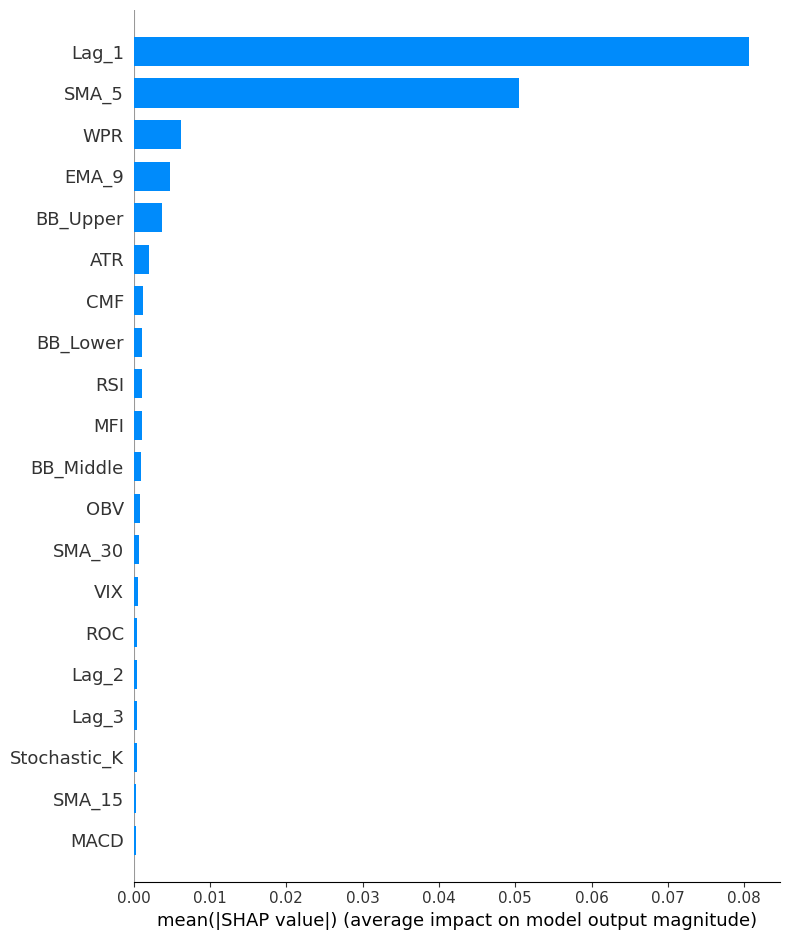


Features with low SHAP importance (should consider deleting for next training):
Month
DayOfWeek
Lag_5
Lag_4
SMA_10


In [29]:
# -----------------------------------------------
# 1. Permutation Importance
# -----------------------------------------------
# Now, you can use permutation_importance with the XGBRegressor model
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb

class XGBoostBoosterWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, booster_model):
        self.booster_model = booster_model

    def fit(self, X, y):
        # Booster doesn't require a fit method, as it has already been trained
        return self

    def predict(self, X):
        # Use the Booster's predict method to make predictions
        return self.booster_model.predict(xgb.DMatrix(X))

# Wrap the trained Booster model
wrapped_model = XGBoostBoosterWrapper(best_model)

# Now, you can use permutation_importance with this wrapper model
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()

# Plotting Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_columns)[perm_sorted_idx], perm_importance.importances_mean[perm_sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

# Print features with low permutation importance (should consider deleting for next training)
print("Features with low permutation importance (should consider deleting for next training):")
for idx in perm_sorted_idx[:5]:  # Top 5 least important features
    print(feature_columns[idx])

# -----------------------------------------------
# 2. SHAP Feature Importance
# -----------------------------------------------
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, plot_type="bar")

# Identifying the features that can be dropped based on SHAP values (low impact features)
shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_sorted_idx = np.argsort(shap_importance)

# Print features with low SHAP importance (should consider deleting)
print("\nFeatures with low SHAP importance (should consider deleting for next training):")
for idx in shap_sorted_idx[:5]:  # Top 5 least important features
    print(feature_columns[idx])

X_test shape: (373, 27)


100%|██████████| 27/27 [00:00<00:00, 270.53it/s]

Evaluating feature importance: Shuffling 'EMA_9'
Evaluating feature importance: Shuffling 'SMA_5'
Evaluating feature importance: Shuffling 'SMA_10'
Evaluating feature importance: Shuffling 'SMA_15'
Evaluating feature importance: Shuffling 'SMA_30'
Evaluating feature importance: Shuffling 'MACD'
Evaluating feature importance: Shuffling 'Signal_Line'
Evaluating feature importance: Shuffling 'RSI'
Evaluating feature importance: Shuffling 'WPR'
Evaluating feature importance: Shuffling 'BB_Middle'
Evaluating feature importance: Shuffling 'BB_Upper'
Evaluating feature importance: Shuffling 'BB_Lower'
Evaluating feature importance: Shuffling 'ATR'
Evaluating feature importance: Shuffling 'Stochastic_K'
Evaluating feature importance: Shuffling 'OBV'
Evaluating feature importance: Shuffling 'CMF'
Evaluating feature importance: Shuffling 'ROC'
Evaluating feature importance: Shuffling 'MFI'
Evaluating feature importance: Shuffling 'DayOfWeek'
Evaluating feature importance: Shuffling 'Month'
Evalu

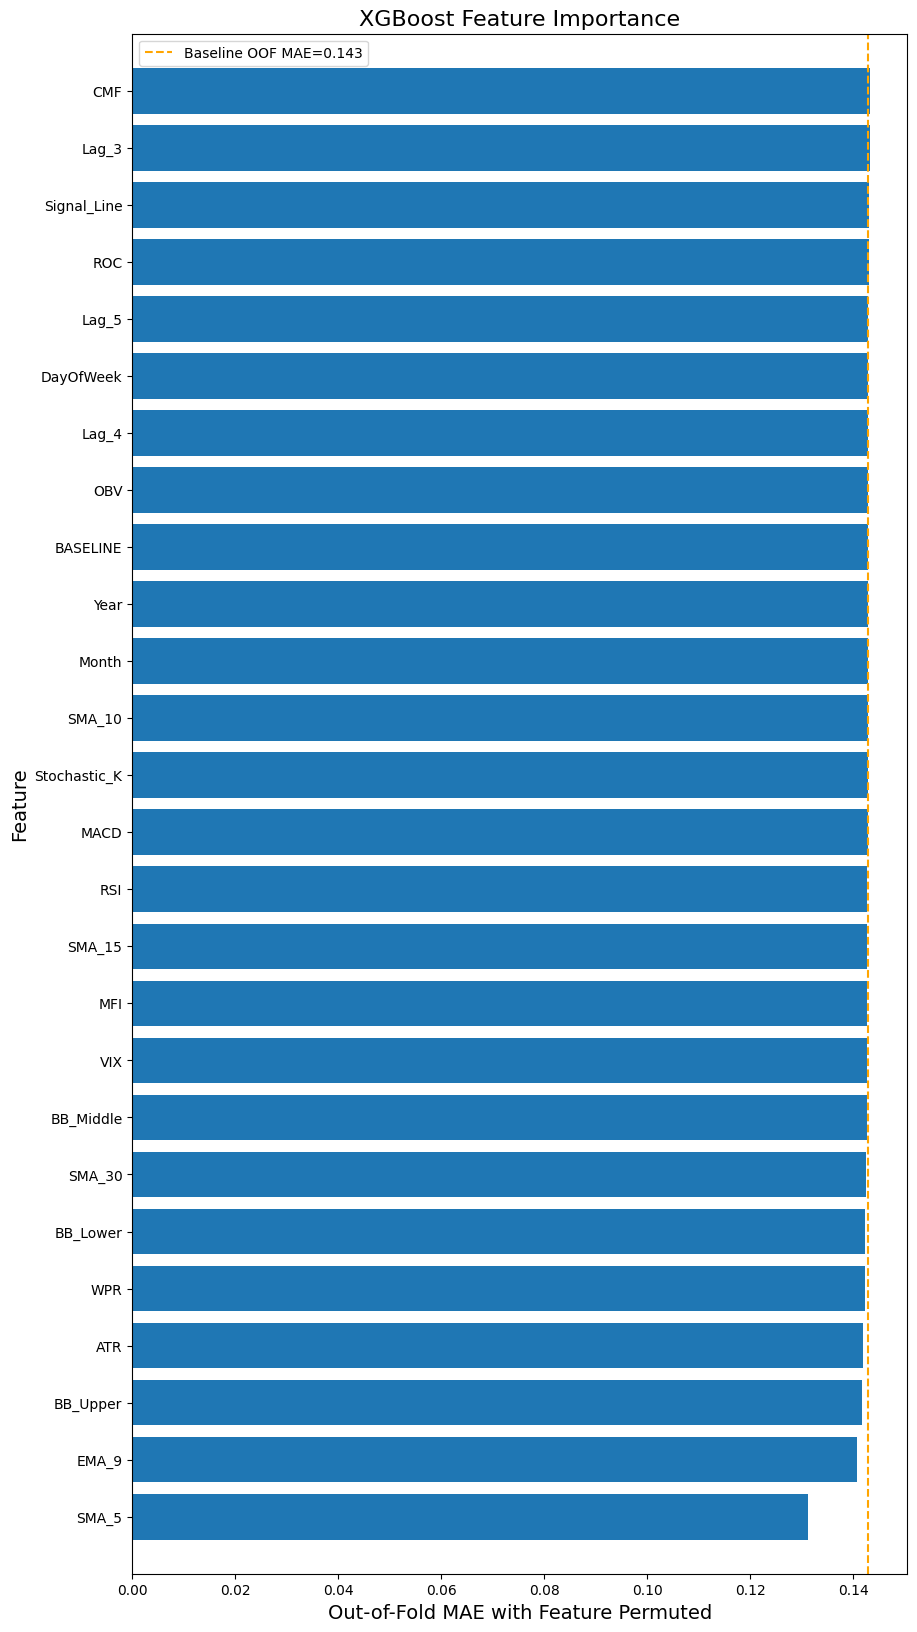

In [34]:
# Ensure X_test is in the correct shape (2D or 3D)
print("X_test shape:", X_test.shape)

# If X_test is 2D (i.e., n_samples, n_features), loop over the second dimension
if len(X_test.shape) == 2:
    num_features = X_test.shape[1]
elif len(X_test.shape) == 3:
    # If it's 3D (i.e., n_samples, time_steps, n_features), loop over the third dimension
    num_features = X_test.shape[2]
else:
    raise ValueError("X_test has an unexpected shape")

# Iterate through each feature and shuffle it
for k in tqdm(range(num_features)):  # Loop through all features (columns)
    # Skip features in the 'features_to_remove' list
    if feature_columns[k] in features_to_remove:
        print(f"Skipping feature '{feature_columns[k]}' (as it is in the removal list).")
        continue  # Skip this feature
    
    # Print the feature being shuffled
    print(f"Evaluating feature importance: Shuffling '{feature_columns[k]}'")
    
    # Save the original column to restore it after shuffling
    save_col = X_test[:, k].copy() if len(X_test.shape) == 2 else X_test[:, :, k].copy()
    
    # Shuffle the feature column
    if len(X_test.shape) == 2:
        np.random.shuffle(X_test[:, k])
    else:
        np.random.shuffle(X_test[:, :, k])
    
    # Convert the shuffled X_test into DMatrix
    dtest = xgb.DMatrix(X_test)
    
    # Get out-of-fold predictions after shuffling the feature
    oof_preds = best_model.predict(dtest).squeeze()
    
    # Calculate MAE with the shuffled feature
    mae = np.mean(np.abs(oof_preds - y_test))
    
    # Store the result for the shuffled feature
    results.append({'feature': feature_columns[k], 'mae': mae})
    
    # Restore the original feature column
    if len(X_test.shape) == 2:
        X_test[:, k] = save_col
    else:
        X_test[:, :, k] = save_col

# Convert results into a DataFrame for easier analysis
df = pd.DataFrame(results)
df = df.sort_values('mae')

# Plot the feature importance
plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(df)), df['mae'])
plt.yticks(np.arange(len(df)), df['feature'].values)
plt.title('XGBoost Feature Importance', size=16)
plt.ylim((-1, len(df)))
plt.axvline(x=baseline_mae, color='orange', linestyle='--', label=f'Baseline OOF MAE={baseline_mae:.3f}')
plt.xlabel('Out-of-Fold MAE with Feature Permuted', size=14)
plt.ylabel('Feature', size=14)
plt.legend()
plt.show()

# Save feature importance to CSV file
df.to_csv('xgboost_feature_importance.csv', index=False)


In [39]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, scaler):
    # Reshape y_true and y_pred to 2D (n_samples, 1) if they are 1D
    y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled)),
        'MAE': mean_absolute_error(y_true_rescaled, y_pred_rescaled),
        'MAPE': mean_absolute_percentage_error(y_true_rescaled, y_pred_rescaled),
        'R2': r2_score(y_true_rescaled, y_pred_rescaled)
    }
    return metrics


# Function to plot predictions
def plot_predictions(y_true, y_pred, dates, scaler, title='XGBoost Stock Prediction'):
    # Reshape y_true and y_pred to 2D (n_samples, 1) if they are 1D
    y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true_rescaled, label='Actual Prices', color='blue')
    plt.plot(dates, y_pred_rescaled, label='XGBoost Predictions', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (IDR)')
    plt.legend()
    plt.show()


Metrics: RMSE=45.66, MAE=28.26, MAPE=0.02%, R2=0.99


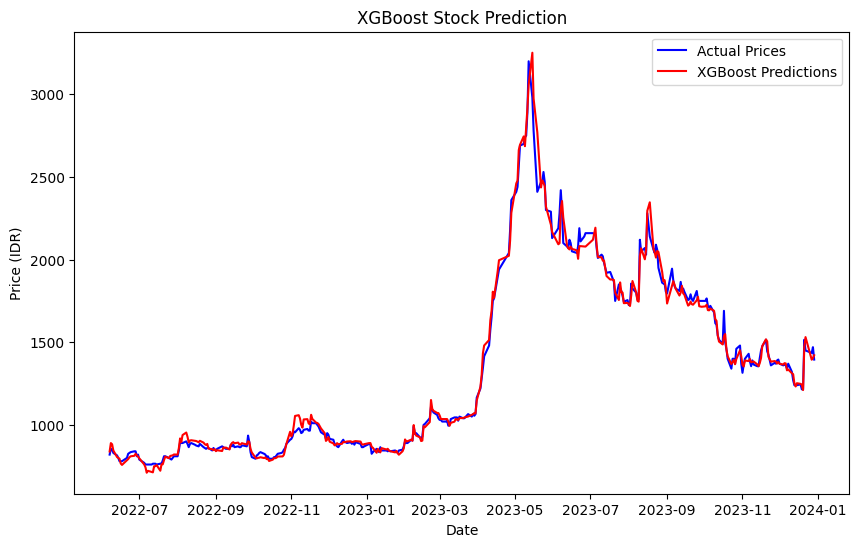

In [40]:
# Evaluate model
metrics = evaluate_model(y_test, predictions, scaler_target)
print(f"Metrics: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, MAPE={metrics['MAPE']:.2f}%, R2={metrics['R2']:.2f}")

# Plot predictions
plot_predictions(y_test, predictions, stock_data.index[-len(y_test):], scaler_target)


In [41]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):], 
                         y=scaler_target.inverse_transform(y_test).flatten(), 
                         mode='lines', name='Actual Prices', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index[-len(predictions):], 
                         y=predictions_rescaled.flatten(), 
                         mode='lines', name='XGBoost Predictions', line=dict(color='red')))
fig.update_layout(title='XGBoost Stock Prediction', xaxis_title='Date', yaxis_title='Price (IDR)')
fig.show()


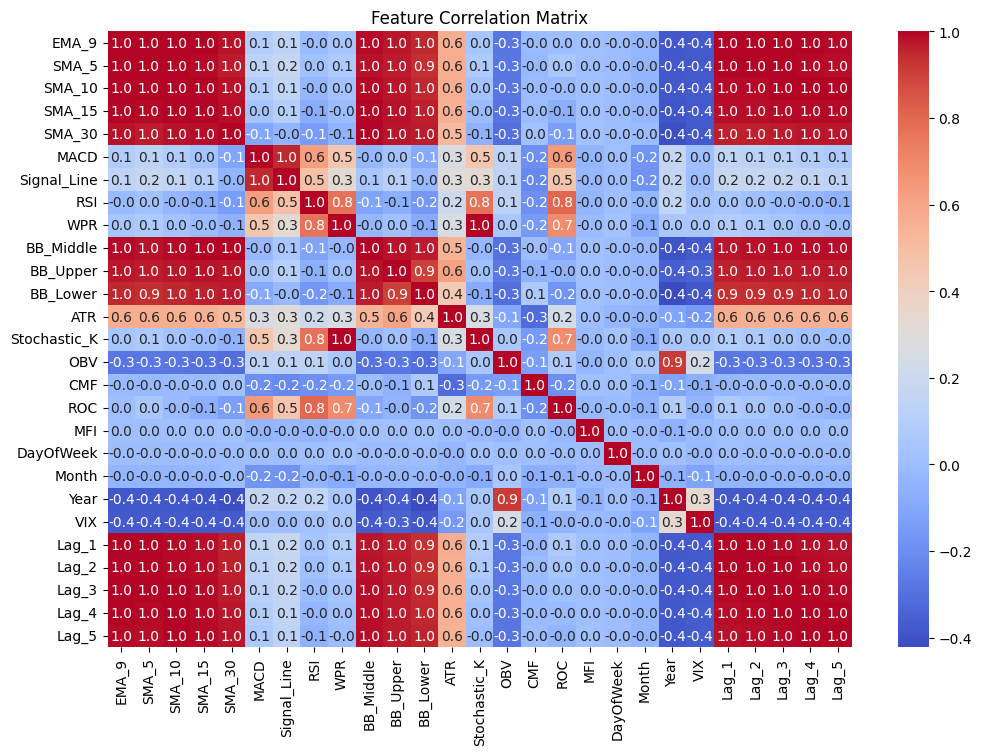

In [42]:
import seaborn as sns

# Correlation matrix
corr_matrix = X.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


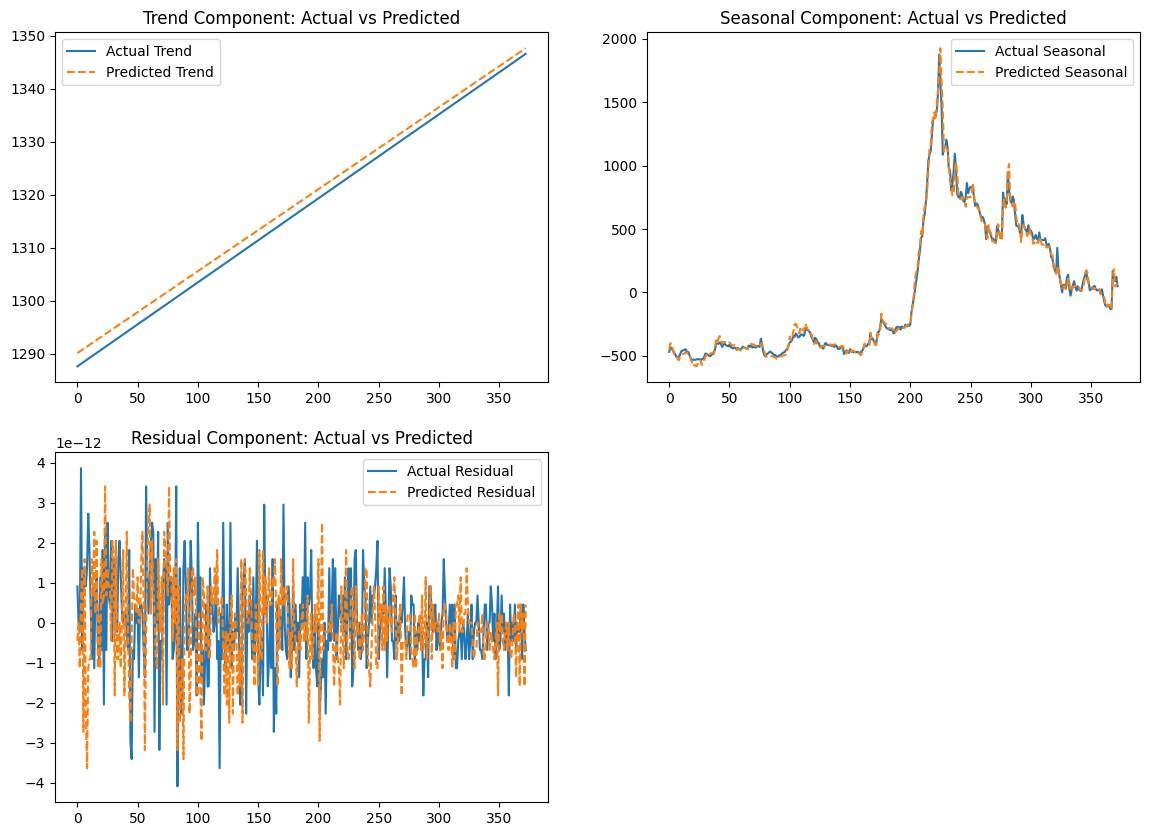

In [45]:
# STL decomposition for trend, seasonal, and residual components
def stl_decompose(data):
    stl = STL(data, period=365)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid

# Decompose actual and predicted data
actual_trend, actual_seasonal, actual_residual = stl_decompose(y_test_rescaled)
pred_trend, pred_seasonal, pred_residual = stl_decompose(predictions_rescaled)

# Plotting
plt.figure(figsize=(14, 10))

# Actual vs Predicted Trend
plt.subplot(2, 2, 1)
plt.plot(actual_trend, label='Actual Trend')
plt.plot(pred_trend, label='Predicted Trend', linestyle='--')
plt.title('Trend Component: Actual vs Predicted')
plt.legend()

# Actual vs Predicted Seasonal
plt.subplot(2, 2, 2)
plt.plot(actual_seasonal, label='Actual Seasonal')
plt.plot(pred_seasonal, label='Predicted Seasonal', linestyle='--')
plt.title('Seasonal Component: Actual vs Predicted')
plt.legend()

# Actual vs Predicted Residual
plt.subplot(2, 2, 3)
plt.plot(actual_residual, label='Actual Residual')
plt.plot(pred_residual, label='Predicted Residual', linestyle='--')
plt.title('Residual Component: Actual vs Predicted')
plt.legend()
